
В этом задании мы предсказыважем год выпуска песни  по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd).

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-20 18:37:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [              <=>   ] 201.24M  75.0MB/s    in 2.7s    

2023-10-20 18:37:18 (75.0 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
Y_train = y[:train_size]
X_test = X[train_size:, :]
Y_test = y[train_size:]

## Определяем бейзлайны

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучим `Ridge` регрессию из `sklearn`. Кроме того, посчитаем качество при наилучшем константном прогнозе.



In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as msse

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
set_random_seed(42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
model = Ridge()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
rmse_for_model =  np.sqrt(msse(Y_test, y_pred))

In [ ]:
rmse_for_model

9.51267116131314

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
best_rmse_metric = np.sqrt(msse(Y_test, np.full_like(Y_test, np.mean(Y_test))))

In [ ]:
best_rmse_metric

10.863228020678134

## Рукописный цикл обучения для одного линейного слоя.

In [ ]:
train_size = 463715
X_train = X[:train_size, :]
Y_train = y[:train_size]
X_test = X[train_size:, :]
Y_test = y[train_size:]

set_random_seed(42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
class linearRegression(torch.nn.Module):
    def __init__(self, input_size, output_size):
      super().__init__()
      self.reg = nn.Linear(90, 1)

    def forward(self, x):
      x = self.reg(x)
      return x


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 1488650.5000, Test Loss: 327601.9062


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 123895.4609, Test Loss: 29348.4648


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 11278.0557, Test Loss: 3127.4985


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 1318.9838, Test Loss: 552.5623


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 317.4276, Test Loss: 230.0319


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 178.1177, Test Loss: 164.9566


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 143.0760, Test Loss: 142.2353


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 128.2233, Test Loss: 131.0764


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 120.1753, Test Loss: 124.6527


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 115.3474, Test Loss: 120.6434


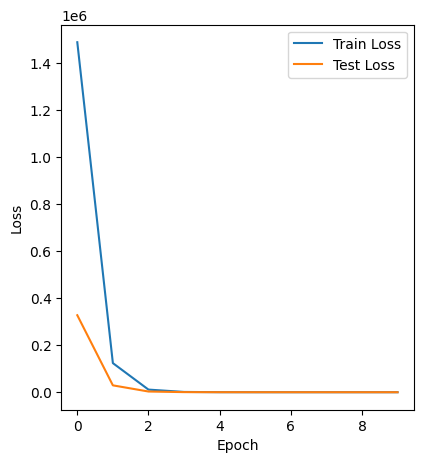

In [ ]:
set_random_seed(40)

X_train = X_train[:20000,:]
X_test = X_test[:4000, :]
Y_train = Y_train[:20000]
Y_test = Y_test[:4000]

X_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True).to(device)
Y_train = torch.tensor(Y_train, dtype=torch.float32, requires_grad=True).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32, requires_grad=True).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.float32, requires_grad=True).to(device)
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size = 32)
test_dataset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size = 32)

model = linearRegression(90, 1)
model.to(device)
learning_rate = 0.001
num_epochs = 10
train_loss_history = []
test_loss_history = []

for epoch in range(num_epochs):
  train_loss = []
  for input, target in tqdm(train_dataloader):
        y_pred = model(input)
        loss = torch.mean(torch.square(target - y_pred))
        train_loss.append(loss.cpu().detach().numpy())
        loss.backward()
        for param in model.parameters():
          with torch.no_grad():
            param -= learning_rate * param.grad
        model.zero_grad()

  test_loss = []
  with torch.no_grad():
    for test_input, test_target in tqdm(test_dataloader):
      y_pred = model(test_input)
      loss = torch.mean(torch.square(test_target - y_pred))
      test_loss.append(loss.cpu().detach().numpy())
    test_loss_history.append(np.mean(test_loss))
    train_loss_history.append(np.mean(train_loss))
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {np.mean(train_loss):.4f}, Test Loss: {np.mean(test_loss):.4f}')


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Все работает

## Стараемся выбить лучшую метрику без ансамблей

### Пробуем:

- **нормировка таргета**.

- избавиться от переобучения с помощью Dropout и Batchnorm


In [ ]:
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import LambdaLR, StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
Y_train = y[:train_size]
X_test = X[train_size:, :]
Y_test = y[train_size:]

In [ ]:
set_random_seed(41)
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_train = X_train[:154624,:]
X_test = X_test[:17024, :]
Y_train = Y_train[:154624] # 1/3 data
Y_test = Y_test[:17024]

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

In [ ]:
set_random_seed(41)
X_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True).to(device)
Y_train_scaled = torch.tensor(Y_train_scaled, dtype=torch.float32, requires_grad=True).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32, requires_grad=True).to(device)
Y_test_scaled = torch.tensor(Y_test_scaled, dtype=torch.float32, requires_grad=True).to(device)
train_dataset = TensorDataset(X_train, Y_train_scaled)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle = True, num_workers = 0)
test_dataset = TensorDataset(X_test, Y_test_scaled)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle = False, num_workers = 0)

model = nn.Sequential(
    nn.Linear(90 * 1, 256),
    # nn.BatchNorm1d(128),
    nn.PReLU(),
    # nn.Dropout(0.2),
    nn.Linear(256, 128),
    # nn.BatchNorm1d(64),
    nn.PReLU(),
    # nn.Dropout(0.3),
    nn.Linear(128, 1)
)
model.to(device)

# def lr_lambda(epoch):
#     if epoch == 3:
#       return 0.7
#     elif epoch > 3 and epoch % 2 == 0:
#       return 0.75
#     else:
#       return 1

learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.025)
criterion = torch.nn.MSELoss()
# scheduler = lr_scheduler.StepLR(optimizer, step_size=70, gamma=0.92)
# scheduler = LambdaLR(optimizer, lr_lambda)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=0, factor=0.5, verbose=True)

In [ ]:
def sse(y, y_pred):
    y, y_pred = torch.tensor(y).to(device), torch.tensor(y_pred).to(device)
    return torch.sum((y - y_pred)**2).item()

def train(model, optimizer, criterion, train_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
    # predicts = []
    train_mse = 0
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_mse += loss.item()
        # target_denorm = scaler_Y.inverse_transform(targets.cpu().detach().numpy())
        # output_denorm = scaler_Y.inverse_transform(outputs.cpu().detach().numpy())
        # train_sse += sse(targets, outputs) # чтоб оптимзировать, нам не важен в целом трейн лосс, достаточно наблюдать за его трендом
        # predicts.extend(outputs)
    # return torch.cat(predicts)
    train_rmse = np.sqrt(train_mse / len(train_loader))
    return train_rmse


def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    predicts = []
    test_sse = 0
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predicts.extend(outputs)
            target_denorm = scaler_Y.inverse_transform(targets.cpu().detach().numpy())
            output_denorm = scaler_Y.inverse_transform(outputs.cpu().detach().numpy())
            test_sse += sse(target_denorm, output_denorm)
    test_rmse = np.sqrt(test_sse / len(Y_test_scaled))
    return torch.cat(predicts), test_rmse


In [ ]:
assert test(model, criterion, test_loader)[0].shape[0] == Y_test_scaled.shape[0]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.8522, Test Loss: 9.0715


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.8314, Test Loss: 9.0272


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.8265, Test Loss: 8.9765


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.8226, Test Loss: 8.9247


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.8207, Test Loss: 8.8711


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 2.5000e-04.
Epoch [6/20], Train Loss: 0.8184, Test Loss: 8.9302


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 1.2500e-04.
Epoch [7/20], Train Loss: 0.8134, Test Loss: 8.8782


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.8095, Test Loss: 8.8426


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 6.2500e-05.
Epoch [9/20], Train Loss: 0.8082, Test Loss: 8.8485


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.8064, Test Loss: 8.8337


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 3.1250e-05.
Epoch [11/20], Train Loss: 0.8054, Test Loss: 8.8372


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.8044, Test Loss: 8.8279


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.8039, Test Loss: 8.8140


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 00014: reducing learning rate of group 0 to 1.5625e-05.
Epoch [14/20], Train Loss: 0.8037, Test Loss: 8.8205


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 7.8125e-06.
Epoch [15/20], Train Loss: 0.8030, Test Loss: 8.8183


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 00016: reducing learning rate of group 0 to 3.9063e-06.
Epoch [16/20], Train Loss: 0.8025, Test Loss: 8.8181


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 00017: reducing learning rate of group 0 to 1.9531e-06.
Epoch [17/20], Train Loss: 0.8024, Test Loss: 8.8164


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 9.7656e-07.
Epoch [18/20], Train Loss: 0.8023, Test Loss: 8.8171


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 00019: reducing learning rate of group 0 to 4.8828e-07.
Epoch [19/20], Train Loss: 0.8022, Test Loss: 8.8169


  0%|          | 0/1208 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 00020: reducing learning rate of group 0 to 2.4414e-07.
Epoch [20/20], Train Loss: 0.8022, Test Loss: 8.8169


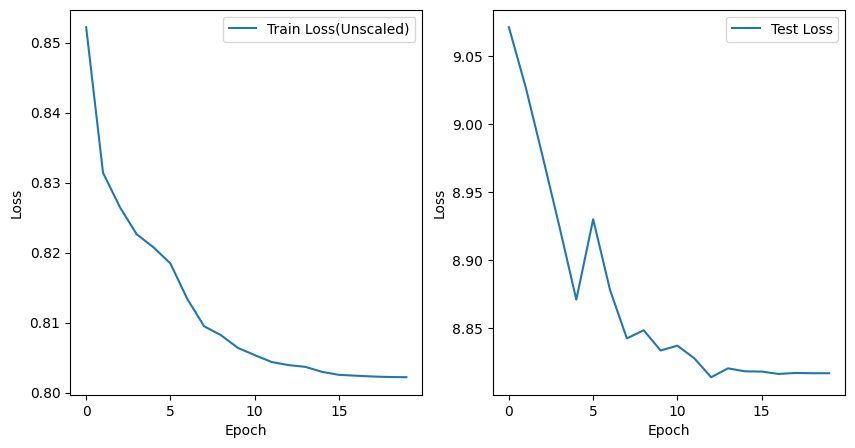

In [ ]:
# ೭੧(❛〜❛✿)੭೨ Go forward!
set_random_seed(41)
num_epochs = 20
train_loss_history = []
test_loss_history = []
for epoch in range(num_epochs):
    train_rmse = train(model, optimizer, criterion, train_loader)
    test_pred, test_rmse = test(model, criterion, test_loader)
    scheduler.step(test_rmse)
    # train_pred_unscaled = scaler_Y.inverse_transform(train_pred.detach().numpy().reshape(-1, 1)).flatten()
    # test_pred_unscaled = scaler_Y.inverse_transform(test_pred.detach().numpy().reshape(-1, 1)).flatten()
    # train_pred_unscaled = scaler_Y.inverse_transform(train_pred.cpu().detach().numpy().reshape(-1, 1)).flatten()
    # test_pred_unscaled = scaler_Y.inverse_transform(test_pred.cpu().detach().numpy().reshape(-1, 1)).flatten()
    # train_loss_history.append(rmse(Y_train, train_pred.detach().numpy()))
    # test_loss_history.append(rmse(Y_test, test_pred.detach().numpy()))
    train_loss_history.append(train_rmse)
    test_loss_history.append(test_rmse)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_rmse:.4f}, Test Loss: {test_rmse:.4f}')
    if test_rmse <= 8.75:
      break


# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(train_loss_history, label='Train Loss')
# plt.plot(test_loss_history, label='Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')

# plt.legend()
# plt.show()


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss(Unscaled)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Итоги


По советам чата использую Adam.
Сначала я создал обычную полносвязную нейронку без всяких приколов, типа дропаута и батчнорма. Эксприментировал с learning_rate - "скорость обучения" модели. Наименьший рмсе с такой моделькой у меня получилось = 9.3192 , при lr = 0.00002 и число эпох = 100. Получилось, что понижение lr приводит к падению лосса, но для этого требуется намного больше эпох, чтобы модель пришла к оптимуму, а если выбрать слишком маленький lr, то может и не прийти за мильон эпох. Не стал добиваться тут рекордного лосса, все равно не было бы нужного.


Далее, я поэкспериментировал с размерами батчей. Просто поменял batch_size на 32(дефолт = 1), и получилось, что модель практически не меняется с каждой эпохой - lr оказывается слишком маленьким - увеличим до 0.0003. Также, я уменьшил выборку в 50 раз до этого, при увеличении размера батча можно расширить чуть выборку. Уменьшу в 25 на этот раз. За 50 эпох получилось рмсе = 9.39 , но было потенциал упасть еще, зафиксируем. Попробуем поднять батчсайз до 64, чтоб посмотреть, что поменяется. Рмсе получилось = 17.16, но падало на 1 с каждой эпохой, 50 эпох не хватило, к сожалению. Оставим батчсайз = 32.


Попробуем добавить в модель батчнорм и дропаут. Чуть чуть повысим lr = 0.00033, по предыдущему опыту, модели не успевали дойти до оптимума, и прогоним 100 эпох. К 70 эпохе лосс застрял на 150. Повысим lr еще. 0.0005 -  не помогло. 0.001 - тоже не помогло. Лосс встревает в районе 150. Значит дело не в learning rate. Попробуем убрать дропаут. Границу в 150 пробили, дело было в нем. В районе 20 опять начинает колебаться вверх вниз - умньшим lr = 0.00075. Same shit. lr = 0.00025  НЕ ПОМОГЛО. батчсайз = 64, lr = 0.0005. слишком медленно обучается... lr = 0.001 - медленно... lr = 0.0015 НЕ ПОМОГЛО

Не хотел я к этому приходить потому что сложнаа, но ладно, нормализуем таргет + увеличим lr = 0.005. попробуем дропаут - 8.89! Надо похимичить еще. Пробую lr = 0.01 + увеличиваю выборку. Модель переобучается.

2 дня спустя

я неправильно считал рмсе так что все на смарку, но выводы я все равно сделал



без дропа и батчнорма в итоге lr = 0.00005, gamma =0.9(lr_scheduler), переобучилась модель рекордный тест рмсе = 8.94

увеличил число нейронов в архитектуре в два раза в каждом слое

попробовал ввести дропаут 0.2, увеличил гамму, добавил шафл в трейн даталоадер.
убрал дропаут, переобучается сразу почти

поменял шедулер на кастомный, предварительно посмотрев где модель встревает(22 эпоха)

не получается ниже 8.94, введем регуляризацию weight_decay = 0.001 для начала - не особо спасает, увеличим до 0.01. 8.84 новый рекорд, надо еще повысить, переобучается все равно + настроил кастомный скедулер, чтоб после 20 эпохи каждая третья уменьшала лр. Слишком сильно увеличил декэй, сделаю 0,02

после 10 эпохи сделал изменение лр в скедулере. поднял до 0.025 дикэй, поднял уменьшение лр после 10 эпохи(ПЕРЕОБУЧЕНИЕ)

декэй 0.03, lr каждую вторую понижать.
повышу объем выборки с 10 до 25%. batch_size = 32.
декай 0,035

переобучилась - декэй =0,04 + очень долго обучается, начнем с большего лр

слишком долго и плохо обучается - возвращаем 0.02 дикэй
пробуем другую функцию активации прелу - новый рекод 8.81, но модель переобучается в хлам

подергал коэф скедулинга,дикэй 0.025....

берем четверть выборки, батч 64, lr = 0.0005 остальное все то же - не успел обучить, поймите пожалуйста, сделаю на четверти выборки
я не поздно начал, я делаю эту домашку уже больше 20 часов на 4 разных аккаунтах параллельно, я просто не могу подобрать эти гр****ые параметры для 8.8, а модель на фулл выборку обучается больше часа
как видите, я довольно сильно настрадался, я менял архитектуру(убирал/добавлял дроп, батчнорм, менял функции активации, нейроны), дергал все гиперпараметры миллион раз, перепробовал 3 lr_scheduler'а, создал 6 аккаунтов гугл. В общем, то, что я не удалил из всех попыток, можно увидеть по # в коде

ИТОГО 8.81, я устал



Нужно было просто взять больше слоев, зря мучался